# Evaluation of Probabilistic Retrieval System Implemented

In [1]:
import ProbIR as PIR
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np

The corpus used for testing is called "CISI" (which stands for "Centre for Inventions and Scientific Information") and consists of 1,460 documents and 112 related queries. For each query, a set of relevant documents is given, in order to evaluate how efficient is an IR system in retrieving pertinent documents.

We now import the three needed objects:
- `doc_set` is the corpus, a list of Documents with text and title.
- `qry_set` is a dictionary having as key the ID of the query and as value the query itself.
- `rel_set` is a dictionary having as key the ID of the query and as value the list of pertinent document IDs.

In [2]:
doc_set = []
doc_id = ""
doc_text = ""
with open('./cisi/CISI.ALL') as f:
    lines = ""
    for l in f.readlines():
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    lines = lines.lstrip("\n").split("\n")
doc_count = 0
for l in lines:
    if l.startswith(".I"):
        doc_id = int(l.split(" ")[1].strip())-1
    elif l.startswith(".X"):
        doc_set.append(doc_text.lstrip(" "))
        doc_id = ""
        doc_text = ""
    else:
        doc_text += l.strip()[3:] + " " 
with open('./cisi/CISI.QRY') as f:
    lines = ""
    for l in f.readlines():
        lines += "\n" + l.strip() if l.startswith(".") else " " + l.strip()
    lines = lines.lstrip("\n").split("\n")
for i in range(len(doc_set)):
    doc_set[i] = PIR.Document(str(i),doc_set[i])

qry_set = {}
qry_id = ""
for l in lines:
    if l.startswith(".I"):
        qry_id = int(l.split(" ")[1].strip()) -1
    elif l.startswith(".W"):
        qry_set[qry_id] = l.strip()[3:]
        qry_id = ""

rel_set = {}
with open('./cisi/CISI.REL') as f:
    for l in f.readlines():
        qry_id = int(l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[0]) -1
        doc_id = int(l.lstrip(" ").strip("\n").split("\t")[0].split(" ")[-1])-1
        if qry_id in rel_set:
            rel_set[qry_id].append(doc_id)
        else:
            rel_set[qry_id] = []
            rel_set[qry_id].append(doc_id)

We initialize the information retrieval system with the given documents.

In [24]:
IRS = PIR.ProbIR.from_corpus(doc_set, stemmer=False)

Computing tf scores: 100%|██████████| 12504/12504 [00:00<00:00, 14733.32it/s]


To evaluate the system the Average $R$-precision score will be used, an alternative to the MAP (Mean Average Precision).
Let $Q$ be a set of $n$ queries, and let $R_j$ be the number of relevant documents for the $j$-th query.
Then the ARP is computed as:
$$ ARP(Q) = \sum_{i=1}^{n} \frac{\text{\# relevant documents in the first} R_i \text{ retrieved results}}{R_i}$$

In [4]:
rel_set_toset = set(rel_set)
for i in range(len(qry_set)):
    if(i not in rel_set_toset):
        qry_set.pop(i)
avail_qry = list(qry_set.keys())

In [7]:
B = len(rel_set)
arp = 0
for j in tqdm(range(len(qry_set))):
    results = len(qry_set[avail_qry[j]])
    ret = IRS.query(qry_set[avail_qry[j]], results=results, test_mode=True)
    idx = set([doc.to_int() for doc in ret])
    rel_set_toset = set(rel_set[avail_qry[j]])
    arp += len(idx.intersection(rel_set_toset))/results

print("ARP: ", arp/B)


100%|██████████| 76/76 [00:40<00:00,  1.87it/s]

ARP:  0.09312417930461


## Parameters tuning

In [8]:
b_grid = np.linspace(0,1,11)
k1_grid = np.linspace(1.2,2.4,11)
res = np.zeros((11,11))

B = 50
for i in tqdm(range(len(b_grid)), desc="Grid-search"):
    for j in range(len(k1_grid)):
        arp = 0
        for k in range(B): 
            results = len(rel_set[avail_qry[j]])
            rel_set_toset = set(rel_set[avail_qry[j]])
            ret = IRS.query(qry_set[avail_qry[j]], results=results, b=b_grid[i],k=k1_grid[j], pseudorel=0, test_mode=True)
            idx = set([doc.to_int() for doc in ret])
            arp += len(idx.intersection(rel_set_toset))/results
        res[i][j] = arp/B

Grid-search: 100%|██████████| 11/11 [12:24<00:00, 67.66s/it]


In [114]:
print("Maximum ARP: ", res.max())
print("Parameters: b=",b_grid[int(res.argmax()/11)], ",k1=", k1_grid[res.argmax()%11])

Maximum ARP:  0.3478260869565217
Parameters: b= 1.0 ,k1= 1.2


## Test of the system with best parameters

In [17]:
arp = 0
B= 26
b = 1
k1 = 1.2
for j in tqdm(range(50,76)): 
        results = len(rel_set[avail_qry[j]])
        rel_set_toset = set(rel_set[avail_qry[j]])
        ret = IRS.query(qry_set[avail_qry[j]], results=results, b=b,k=k1, pseudorel=0, test_mode=True)
        idx = set([doc.to_int() for doc in ret])
        arp += len(idx.intersection(rel_set_toset))/results


print("ARP: ", arp/B)

100%|██████████| 26/26 [00:26<00:00,  1.03s/it]

ARP:  0.21361786748769265


## Does pseudo-relevance feedback positively affect ARP?

In [10]:
avg = 0 
for i in range(len(rel_set)):
    avg += len(rel_set[avail_qry[i]])

print("Avg. number of relevant documents:", avg/76)

Avg. number of relevant documents: 40.973684210526315


In [18]:
pseudo_grid = [5,10,25,50,100]
arp = np.zeros(len(pseudo_grid))

for i in tqdm(range(len(pseudo_grid))):
    ap = 0
    for j in (range(50,76)): 
        results = len(rel_set[avail_qry[j]])
        rel_set_toset = set(rel_set[avail_qry[j]])
        ret = IRS.query(qry_set[avail_qry[j]],b = b, k = k1,results=results, pseudorel=pseudo_grid[i], test_mode=True)
        idx = set([doc.to_int() for doc in ret])
        ap += len(idx.intersection(rel_set_toset))/results
    arp[i] = ap/B


100%|██████████| 5/5 [05:20<00:00, 64.16s/it]


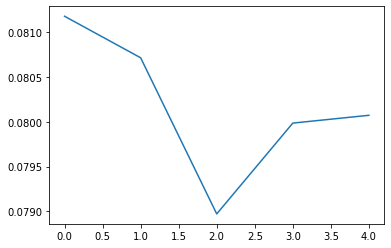

In [19]:
plt.plot(arp)

## Stemming improves results?

In [23]:
IRS = PIR.ProbIR.from_corpus(doc_set, stemmer=True)

Computing tf scores: 100%|██████████| 12504/12504 [00:00<00:00, 13778.66it/s]


In [21]:
arp = 0

b = 1
k1 = 1.2
for j in tqdm(range(50,76)): 
        results = len(rel_set[avail_qry[j]])
        rel_set_toset = set(rel_set[avail_qry[j]])
        ret = IRS.query(qry_set[avail_qry[j]], results=results, b=b,k=k1, pseudorel=0, test_mode=True)
        idx = set([doc.to_int() for doc in ret])
        arp += len(idx.intersection(rel_set_toset))/results


print("ARP: ", arp/B)

100%|██████████| 26/26 [00:26<00:00,  1.00s/it]

ARP:  0.21361786748769265
